# Predictive coding

In this tutorial we explore how the `predictive_coding` library can be used to train a predictive coding network. 

We first cover the basic of the library. Then we illustrate the use of the library for supervised and unsupervised learning on the MNIST dataset

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import random
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy 

import predictive_coding as pc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'using {device}')

using cuda


### What is predictive coding?

### The `predictive_coding` library

Predictive coding models can be constructed in Pytorch using the Sequential module by incorporating `PCLayer()` to define a layer with neural activity. A predictive coding model for supervised learning on the MNIST dataset can for instance be defined as shown below.

In [6]:
input_size = 10        # for the 10 classes
hidden_size = 256
hidden2_size = 256
output_size = 28*28    # for the 28 by 28 mnist images
activation_fn = nn.ReLU

pc_model = nn.Sequential(
      nn.Linear(input_size, hidden_size),
      pc.PCLayer(),         # contains neural activity of layer 2                  
      activation_fn(),
      nn.Linear(hidden_size, hidden2_size),
      pc.PCLayer(),         # contains neural activity of layer 1
      activation_fn(),
      nn.Linear(hidden2_size, output_size)
  )
pc_model.train()

Sequential(
  (0): Linear(in_features=10, out_features=256, bias=True)
  (1): PCLayer()
  (2): ReLU()
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): PCLayer()
  (5): ReLU()
  (6): Linear(in_features=256, out_features=784, bias=True)
)

The predictive_coding library employs `PCTrainer` to train a predictive coding model. This trainer iteratively updates the neural activity for T steps followed by a weight update.
A `PCTrainer` can be defined as follows

In [7]:
# number of neural activity updates
T = 20                              
# optimizer for activity updates
optimizer_x_fn = optim.Adam         
optimizer_x_kwargs = {'lr': 0.1}    
# optimizer for weight updates
optimizer_p_fn = optim.Adam          
optimizer_p_kwargs = {"lr": 0.001, "weight_decay":0.001} 

trainer = pc.PCTrainer(pc_model, 
    T = T, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs
)

### Supervised learning using predictive coding

A predictive coding model can be trained in a supervised setting where both data and labels are available. In this case, the model is trained by clamping the inputs neurons to the data and clamping the highest latent layer to the labels. A trained model can then be used for classification as well as generation, denoising and image completion.    

In [8]:
# set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)

n_train = 10000
n_val = 500
n_test = 5000
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])
dataset_train = datasets.MNIST('./data', download=True, train=True, transform=transform)
dataset_eval = datasets.MNIST('./data', download=True, train=False, transform=transform)

# Randomly sample the train dataset
train_dataset = torch.utils.data.Subset(dataset_train, random.sample(range(len(dataset_train)), n_train))

# Randomly sample the val dataset
val_dataset, test_dataset, not_used = torch.utils.data.random_split(dataset_eval, [n_val, n_test, dataset_eval.__len__()-n_val-n_test])

print(f'train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}')

train: 10000, val: 500, test: 5000


In [14]:
# define model
input_size = 10
hidden_size = 256
output_size = 28*28
num_hidden_layers = 1
activation_fn = nn.ReLU
is_bias = False
is_sigmoid = False

def get_model(input_size, hidden_size, output_size, activation_fn, num_hidden_layers, is_bias=True, is_sigmoid=True):
    layers = []
    if num_hidden_layers == 0:
        layers.append(nn.Linear(input_size, output_size, bias=is_bias))
    elif num_hidden_layers >= 1:
        layers.append(nn.Linear(input_size, hidden_size, bias=is_bias))
        layers.append(pc.PCLayer())
        layers.append(activation_fn())
        for _ in range(num_hidden_layers-1):
            layers.append(nn.Linear(hidden_size, hidden_size, bias=is_bias))
            layers.append(pc.PCLayer())
            layers.append(activation_fn())
        layers.append(nn.Linear(hidden_size, output_size, bias=is_bias))
    else:
        raise ValueError('num_hidden_layers must be a non-negative integer')
    if is_sigmoid:
        layers.append(nn.Sigmoid())
    return nn.Sequential(*layers)

pc_model = get_model(input_size, hidden_size, output_size, activation_fn, num_hidden_layers, is_bias=is_bias, is_sigmoid=is_sigmoid)
pc_model.train()
pc_model.to(device)


# define trainer
T = 20                             # number of inference iterations
update_x_at = 'all'                 # update latent state x at every iteration
optimizer_x_fn = optim.Adam         # optimizer for latent state x
optimizer_x_kwargs = {'lr': 0.1}    # optimizer parameters for latent state x
update_p_at = 'last'                # update parameters p at the last iteration
optimizer_p_fn = optim.Adam          # optimizer for parameters p
optimizer_p_kwargs = {"lr": 0.001, "weight_decay":0.001} # optimizer parameters for parameters p
plot_progress_at = []            # plot progress every inference iterations

trainer = pc.PCTrainer(pc_model, 
    T = T, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = update_p_at,   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

In [15]:
## define utility functions

# energy function of the input layer of the predictive coding model
def loss_fn_default(output, _target, _reduction='none'):
    return 0.5*(output - _target).pow(2).sum()

# This class is used to add a bias to the top layer of a predictive coding model. This layer can be learned or initialised to a default value.
class Bias(nn.Module):
    def __init__(self, out_features, offset=0.):
        super(Bias, self).__init__()
        self.bias = nn.Parameter(offset*torch.ones(out_features) if offset is not None else 2*np.sqrt(out_features)*torch.rand(out_features)-np.sqrt(out_features), requires_grad=True)

    def forward(self, x):
        return torch.zeros_like(x) + self.bias  # return the prior mean \mu witht the same shape as the input x to make sure the batch size is the same


def classify(model, dataset, batch_size=1000):
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # add bias layer for inferece
    test_model = nn.Sequential(
        Bias(10, offset=0.1),   # add a bias layer to the top layer with mean 0.1 because each class has 1/10 probability
        pc.PCLayer(energy_fn= lambda inputs: torch.tensor(0)),
        model
    )
    test_model.train()
    test_model.to(device)

    # make pc_trainer for test_model   
    trainer_normal_test = pc.PCTrainer(test_model, 
        T = 120, 
        update_x_at = update_x_at, 
        optimizer_x_fn = optimizer_x_fn,
        optimizer_x_kwargs = optimizer_x_kwargs,
        update_p_at = "never",   
        optimizer_p_fn = optimizer_p_fn,
        optimizer_p_kwargs = optimizer_p_kwargs,
        plot_progress_at= plot_progress_at
    )

    correct_count, all_count = 0., 0.
    for data, labels in (test_loader):
        pseudo_input = torch.zeros(data.shape[0], 10)
        data, labels, pseudo_input = data.to(device), labels.to(device), pseudo_input.to(device)
        
        # MAP inference
        trainer_normal_test.train_on_batch(inputs=pseudo_input, loss_fn=loss_fn_default, loss_fn_kwargs={'_target':data}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
        pred = torch.max(test_model[1].get_x(), dim=1)
        correct = (pred.indices == labels).long()
        correct_count += correct.sum()
        all_count += correct.size(0)
    return round((correct_count / all_count).item(), 4)

Epoch 1: 100%|██████████| 20/20 [00:01<00:00, 16.39it/s]


Epoch 1 -  Val acc: 0.704


Epoch 2: 100%|██████████| 20/20 [00:01<00:00, 16.23it/s]


Epoch 2 -  Val acc: 0.8


Epoch 3: 100%|██████████| 20/20 [00:01<00:00, 16.35it/s]


Epoch 3 -  Val acc: 0.84


Epoch 4: 100%|██████████| 20/20 [00:01<00:00, 16.11it/s]


Epoch 4 -  Val acc: 0.856


Epoch 5: 100%|██████████| 20/20 [00:01<00:00, 16.37it/s]


Epoch 5 -  Val acc: 0.864


Epoch 6: 100%|██████████| 20/20 [00:01<00:00, 15.29it/s]


Epoch 6 -  Val acc: 0.872


Epoch 7: 100%|██████████| 20/20 [00:01<00:00, 16.22it/s]


Epoch 7 -  Val acc: 0.87


Epoch 8: 100%|██████████| 20/20 [00:01<00:00, 16.05it/s]


Epoch 8 -  Val acc: 0.876


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 16.33it/s]


Epoch 9 -  Val acc: 0.874


Epoch 10: 100%|██████████| 20/20 [00:01<00:00, 16.55it/s]


Epoch 10 -  Val acc: 0.872
Test accuracy: 0.871


Text(0.5, 1.0, 'Normal PC with test accuracy: 0.871')

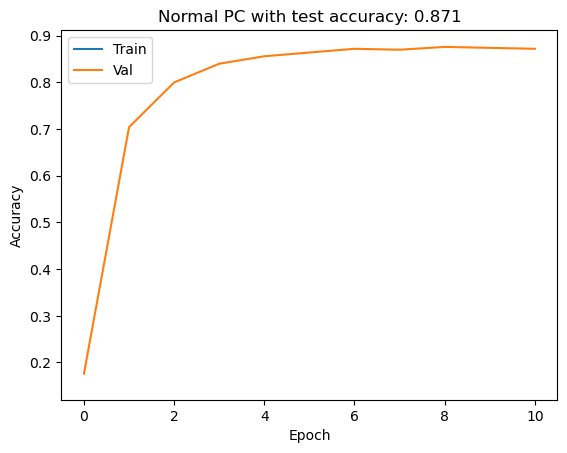

In [16]:
epochs = 10
batch_size = 500
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

best_val_acc = 0
best_model = copy.deepcopy(pc_model.state_dict())

train_acc = [classify(pc_model, test_dataset)]
val_acc = [classify(pc_model, val_dataset)]
for epoch in range(epochs):
    for data, label in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
        data, label = data.to(device), label.to(device)
        # labels to one-hot
        labels_one_hot = F.one_hot(label).float()
        trainer.train_on_batch(inputs=labels_one_hot, loss_fn=loss_fn_default, loss_fn_kwargs={'_target':data}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
    # train_acc.append(test_normal(pc_normal, train_dataset))
    val_acc.append(classify(pc_model, val_dataset))
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        best_model = copy.deepcopy(pc_model.state_dict())
    print(f'Epoch {epoch+1} -  Val acc: {val_acc[-1]}')

    
test_model = get_model(input_size, hidden_size, output_size, activation_fn, num_hidden_layers, is_bias=is_bias, is_sigmoid=is_sigmoid)
test_model.train()
test_model.load_state_dict(best_model, strict=False)
test_model.to(device)
acc_test = classify(test_model, test_dataset)
print(f'Test accuracy: {acc_test}')


plt.plot(val_acc, label='Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Normal PC with test accuracy: {acc_test}')

### Unsupervised learning using predictive coding

using cuda


In [11]:
# utils
# This class contains the parameters of the prior mean \mu parameter (see figure)
class BiasLayer(nn.Module):
    def __init__(self, out_features, offset=0.):
        super(BiasLayer, self).__init__()
        self.bias = nn.Parameter(offset*torch.ones(out_features) if offset is not None else 2*np.sqrt(out_features)*torch.rand(out_features)-np.sqrt(out_features), requires_grad=True)

    def forward(self, x):
        return torch.zeros_like(x) + self.bias  # return the prior mean \mu witht the same shape as the input x to make sure the batch size is the same


In [12]:
# set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)

n_train = 10000
n_val = 500
n_test = 5000
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])
dataset_train = datasets.MNIST('./data', download=True, train=True, transform=transform)
dataset_eval = datasets.MNIST('./data', download=True, train=False, transform=transform)

# Randomly sample the train dataset
train_dataset = torch.utils.data.Subset(dataset_train, random.sample(range(len(dataset_train)), n_train))

# Randomly sample the val dataset
val_dataset, test_dataset, not_used = torch.utils.data.random_split(dataset_eval, [n_val, n_test, dataset_eval.__len__()-n_val-n_test])

print(f'train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}')

train: 10000, val: 500, test: 5000


PC reversed direction

In [351]:
input_size = 28*28
hidden_size = 256
hidden2_size = 256
output_size = 10

# activation_fn = nn.ReLU
activation_fn = nn.Tanh

def get_model(input_size, hidden_size, hidden2_size ,output_size, activation_fn, is_bias=True):
    return nn.Sequential(
        nn.Linear(input_size, hidden_size, bias=is_bias),
        pc.PCLayer(),
        activation_fn(),
        nn.Linear(hidden_size, hidden_size, bias=is_bias),
        pc.PCLayer(),
        activation_fn(),
        nn.Linear(hidden_size, output_size, bias=is_bias),
        nn.Sigmoid()
    )

pc_reversed = get_model(input_size, hidden_size, hidden2_size, output_size, activation_fn)
pc_reversed.train()
pc_reversed.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): PCLayer()
  (2): Tanh()
  (3): Linear(in_features=256, out_features=256, bias=True)
  (4): PCLayer()
  (5): Tanh()
  (6): Linear(in_features=256, out_features=10, bias=True)
  (7): Sigmoid()
)

In [5]:
T = 20                             # number of inference iterations
update_x_at = 'all'                 # update latent state x at every iteration
optimizer_x_fn = optim.SGD         # optimizer for latent state x
optimizer_x_kwargs = {'lr': 0.01}    # optimizer parameters for latent state x
update_p_at = 'last'               # update parameters p at the last iteration
optimizer_p_fn = optim.Adam          # optimizer for parameters p
optimizer_p_kwargs = {'lr': 0.01, "weight_decay":0.0} # optimizer parameters for parameters p
plot_progress_at = []            # plot progress every inference iterations

trainer_reversed = pc.PCTrainer(pc_reversed, 
    T = T, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = update_p_at,   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at,
)

def test_reversed(model, dataset, batch_size=1000):
    model.eval()
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    correct = 0
    total = 0
    for data, label in test_loader:
        data, label = data.to(device), label.to(device)
        pred = model(data)
        _, predicted = torch.max(pred, -1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
    model.train()
    return round(correct / total, 4)

Epoch 1: 100%|██████████| 20/20 [00:01<00:00, 12.97it/s]


Epoch 1 - Train acc: 0.8874, Val acc: 0.894


Epoch 2: 100%|██████████| 20/20 [00:01<00:00, 13.42it/s]


Epoch 2 - Train acc: 0.9238, Val acc: 0.93


Epoch 3: 100%|██████████| 20/20 [00:01<00:00, 13.96it/s]


Epoch 3 - Train acc: 0.9368, Val acc: 0.94


Epoch 4: 100%|██████████| 20/20 [00:01<00:00, 13.98it/s]


Epoch 4 - Train acc: 0.9464, Val acc: 0.958


Epoch 5: 100%|██████████| 20/20 [00:01<00:00, 13.77it/s]


Epoch 5 - Train acc: 0.9504, Val acc: 0.944


Epoch 6: 100%|██████████| 20/20 [00:01<00:00, 13.86it/s]


Epoch 6 - Train acc: 0.955, Val acc: 0.962


Epoch 7: 100%|██████████| 20/20 [00:01<00:00, 14.44it/s]


Epoch 7 - Train acc: 0.9564, Val acc: 0.968


Epoch 8: 100%|██████████| 20/20 [00:01<00:00, 14.24it/s]


Epoch 8 - Train acc: 0.9532, Val acc: 0.966


Epoch 9: 100%|██████████| 20/20 [00:01<00:00, 14.12it/s]


Epoch 9 - Train acc: 0.9556, Val acc: 0.956


Epoch 10: 100%|██████████| 20/20 [00:01<00:00, 14.08it/s]


Epoch 10 - Train acc: 0.9532, Val acc: 0.966
Test accuracy: 0.9564


Text(0.5, 1.0, 'Reversed PC with test accuracy: 0.9564')

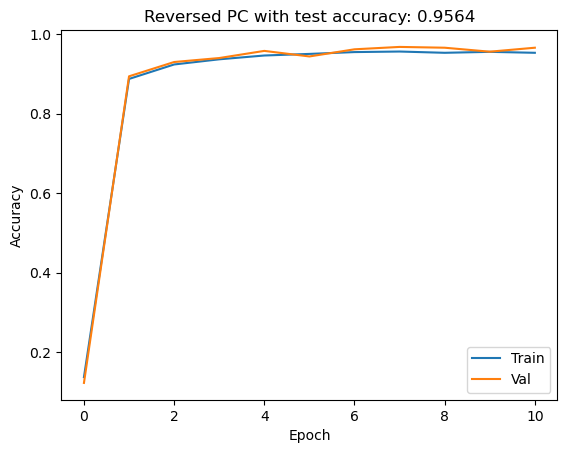

In [6]:
epochs = 10
batch_size = 500
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

CE_loss = nn.CrossEntropyLoss()
loss_fn = lambda output, _target: CE_loss(output, _target)

best_val_acc = 0
best_model = copy.deepcopy(pc_reversed.state_dict())

train_acc = [test_reversed(pc_reversed, test_dataset)]
val_acc = [test_reversed(pc_reversed, val_dataset)]
for epoch in range(epochs):
    for data, label in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
        data, label = data.to(device), label.to(device)
        trainer_reversed.train_on_batch(inputs=data, loss_fn=loss_fn, loss_fn_kwargs={'_target':label}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
    train_acc.append(test_reversed(pc_reversed, test_dataset))
    val_acc.append(test_reversed(pc_reversed, val_dataset))
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        best_model = copy.deepcopy(pc_reversed.state_dict())
    print(f'Epoch {epoch+1} - Train acc: {train_acc[-1]}, Val acc: {val_acc[-1]}')

    
test_model = get_model(input_size, hidden_size, hidden2_size, output_size, activation_fn)
test_model.load_state_dict(best_model, strict=False)
test_model.to(device)
acc_test = test_reversed(test_model, test_dataset)
print(f'Test accuracy: {acc_test}')


plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Reversed PC with test accuracy: {acc_test}')

100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


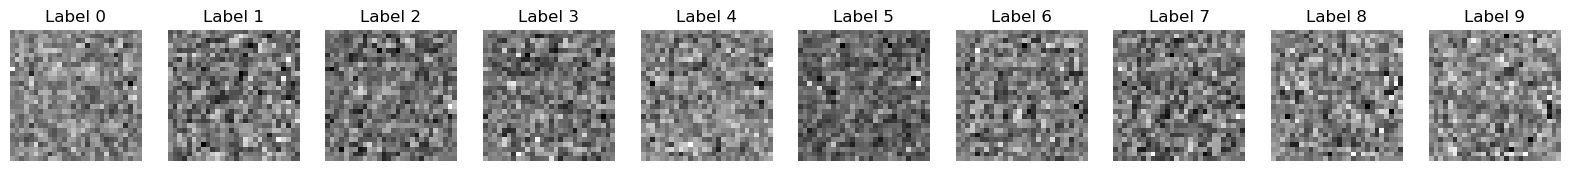

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10000, shuffle=True)
data, label = next(iter(train_loader))

avg_img = torch.mean(data, 0)

# generation
generation_model = nn.Sequential(
    BiasLayer(28*28, offset=0.),
    pc.PCLayer(energy_fn= lambda inputs: torch.tensor(0)),   # sets uniform prior on the top layer
    test_model[:],
)
generation_model.train()
generation_model.to(device)


gen_trainer = pc.PCTrainer(generation_model,
    T = 1000, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = {'lr': 0.01},
    update_p_at = "never",   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= []#"all",
)

imgs = []
for i in tqdm(range(10)):
    label = torch.zeros(1,10)
    label[0, i] = 1
    pseudo_input = torch.zeros(1, 28*28)
    pseudo_input, label = pseudo_input.to(device), label.to(device)
    gen_trainer.train_on_batch(inputs=pseudo_input, loss_fn=loss_fn, loss_fn_kwargs={'_target':label}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
    imgs.append(generation_model[1]._x.detach().cpu().numpy().reshape(28,28))
    
fig, ax = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    ax[i].imshow(imgs[i], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Label {i}')

In [108]:
imgs[0].max()

0.84681106

In [30]:
# brute force tuning
x_optm = [optim.Adam, optim.SGD]
lr_x = [1e-3, 1e-2, 1e-1, 1]
p_optm = [optim.Adam, optim.SGD]
lr_p = [1e-3, 1e-2, 1e-1, 1]
weight_decay = [0, 1e-3, 1e-2, 1e-1]
activation_fns = [nn.ReLU, nn.Tanh]
best_val_acc_tuning = 0
best_params = None

for lr_x_ in tqdm(lr_x):
    for lr_p_ in lr_p:
        for weight_decay_ in weight_decay:
            for optimizer_x_fn in x_optm:
                for optimizer_p_fn in p_optm:
                    for activation_fn_ in activation_fns:
                        input_size = 28*28
                        hidden_size = 256
                        hidden2_size = 256
                        output_size = 10

                        pc_reversed = get_model(input_size, hidden_size, hidden2_size, output_size, activation_fn)
                        pc_reversed.train()
                        pc_reversed.to(device)

                        T = 20                             # number of inference iterations
                        update_x_at = 'all'                 # update latent state x at every iteration
                        optimizer_x_fn = optimizer_x_fn         # optimizer for latent state x
                        optimizer_x_kwargs = {'lr': lr_x_}    # optimizer parameters for latent state x
                        update_p_at = 'last'               # update parameters p at the last iteration
                        optimizer_p_fn = optimizer_p_fn          # optimizer for parameters p
                        optimizer_p_kwargs = {'lr': lr_p_, "weight_decay":weight_decay_} # optimizer parameters for parameters p
                        plot_progress_at = []            # plot progress every inference iterations

                        trainer_reversed = pc.PCTrainer(pc_reversed, 
                            T = T, 
                            update_x_at = update_x_at, 
                            optimizer_x_fn = optimizer_x_fn,
                            optimizer_x_kwargs = optimizer_x_kwargs,
                            update_p_at = update_p_at,   
                            optimizer_p_fn = optimizer_p_fn,
                            optimizer_p_kwargs = optimizer_p_kwargs,
                            plot_progress_at= plot_progress_at,
                        )

                        def test_reversed(model, dataset, batch_size=1000):
                            model.eval()
                            test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
                            correct = 0
                            total = 0
                            for data, label in test_loader:
                                data, label = data.to(device), label.to(device)
                                pred = model(data)
                                _, predicted = torch.max(pred, -1)
                                total += label.size(0)
                                correct += (predicted == label).sum().item()
                            model.train()
                            return round(correct / total, 4)


                        epochs = 10
                        batch_size = 500
                        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

                        CE_loss = nn.CrossEntropyLoss()
                        loss_fn = lambda output, _target: CE_loss(output, _target)

                        best_val_acc = 0
                        best_model = copy.deepcopy(pc_reversed.state_dict())

                        train_acc = [test_reversed(pc_reversed, test_dataset)]
                        val_acc = [test_reversed(pc_reversed, val_dataset)]
                        for epoch in range(epochs):
                            for data, label in (train_loader, desc=f'Epoch {epoch+1}'):
                                data, label = data.to(device), label.to(device)
                                trainer_reversed.train_on_batch(inputs=data, loss_fn=loss_fn, loss_fn_kwargs={'_target':label}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
                            train_acc.append(test_reversed(pc_reversed, test_dataset))
                            val_acc.append(test_reversed(pc_reversed, val_dataset))
                            if val_acc[-1] > best_val_acc:
                                best_val_acc = val_acc[-1]
                                best_model = copy.deepcopy(pc_reversed.state_dict())
                    
                        if best_val_acc > best_val_acc_tuning:
                            best_val_acc_tuning = best_val_acc
                            best_params = (lr_x_, lr_p_, weight_decay_, optimizer_x_fn, optimizer_p_fn, activation_fn_)
                            print(f'Best val acc: {best_val_acc_tuning}, Best params - lr_x: {lr_x_}, lr_p: {lr_p_}, weight_decay: {weight_decay_}, optimizer_x_fn: {optimizer_x_fn}, optimizer_p_fn: {optimizer_p_fn}, activation_fn: {activation_fn_}')

print(f'Best val acc: {best_val_acc_tuning}, Best params - lr_x: {best_params[0]}, lr_p: {best_params[1]}, weight_decay: {best_params[2]}, optimizer_x_fn: {best_params[3]}, optimizer_p_fn: {best_params[4]}, activation_fn: {best_params[5]}')
                 

Epoch 10: 100%|██████████| 20/20 [00:03<00:00,  6.43it/s]


Best val acc: 0.682, Best params - lr_x: 0.001, lr_p: 0.001, weight_decay: 0, optimizer_x_fn: <class 'torch.optim.adam.Adam'>, optimizer_p_fn: <class 'torch.optim.adam.Adam'>, activation_fn: <class 'torch.nn.modules.activation.ReLU'>


Epoch 10: 100%|██████████| 20/20 [00:02<00:00,  6.69it/s]


Best val acc: 0.744, Best params - lr_x: 0.001, lr_p: 0.001, weight_decay: 0, optimizer_x_fn: <class 'torch.optim.adam.Adam'>, optimizer_p_fn: <class 'torch.optim.adam.Adam'>, activation_fn: <class 'torch.nn.modules.activation.Tanh'>


Epoch 10: 100%|██████████| 20/20 [00:02<00:00,  7.15it/s]


Best val acc: 0.952, Best params - lr_x: 0.001, lr_p: 0.001, weight_decay: 0, optimizer_x_fn: <class 'torch.optim.sgd.SGD'>, optimizer_p_fn: <class 'torch.optim.adam.Adam'>, activation_fn: <class 'torch.nn.modules.activation.ReLU'>


Epoch 10: 100%|██████████| 20/20 [00:02<00:00,  7.16it/s]


Best val acc: 0.958, Best params - lr_x: 0.01, lr_p: 0.01, weight_decay: 0, optimizer_x_fn: <class 'torch.optim.sgd.SGD'>, optimizer_p_fn: <class 'torch.optim.adam.Adam'>, activation_fn: <class 'torch.nn.modules.activation.ReLU'>


Epoch 10: 100%|██████████| 20/20 [00:02<00:00,  7.08it/s]


Best val acc: 0.964, Best params - lr_x: 0.01, lr_p: 0.01, weight_decay: 0, optimizer_x_fn: <class 'torch.optim.sgd.SGD'>, optimizer_p_fn: <class 'torch.optim.adam.Adam'>, activation_fn: <class 'torch.nn.modules.activation.Tanh'>


100%|██████████| 4/4 [5:37:46<00:00, 5066.54s/it]  

Best val acc: 0.964, Best params - lr_x: 0.01, lr_p: 0.01, weight_decay: 0, optimizer_x_fn: <class 'torch.optim.sgd.SGD'>, optimizer_p_fn: <class 'torch.optim.adam.Adam'>, activation_fn: <class 'torch.nn.modules.activation.Tanh'>


PC normal direction

In [352]:
input_size = 10
hidden_size = 256
hidden2_size = 256
output_size = 28*28

activation_fn = nn.ReLU
# activation_fn = nn.Tanh

pc_normal = get_model(input_size, hidden_size, hidden2_size, output_size, activation_fn, is_bias=False)
pc_normal.train()
pc_normal.to(device)

def loss_fn_normal(output, _target, _reduction='none'):
    return 0.5*(output - _target).pow(2).sum()

In [353]:
T = 20                             # number of inference iterations
update_x_at = 'all'                 # update latent state x at every iteration
optimizer_x_fn = optim.Adam         # optimizer for latent state x
optimizer_x_kwargs = {'lr': 0.1}    # optimizer parameters for latent state x
update_p_at = 'last'                # update parameters p at the last iteration
optimizer_p_fn = optim.Adam          # optimizer for parameters p
optimizer_p_kwargs = {"lr": 0.001, "weight_decay":0.001} # optimizer parameters for parameters p
plot_progress_at = []            # plot progress every inference iterations

trainer_normal = pc.PCTrainer(pc_normal, 
    T = T, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = update_p_at,   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)


def test_normal(model, dataset, batch_size=1000):
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # add bias layer for inferece
    test_model = nn.Sequential(
        BiasLayer(10, offset=0.2),
        pc.PCLayer(energy_fn= lambda inputs: torch.tensor(0)),
        model
    )
    test_model.train()
    test_model.to(device)

    # make pc_trainer for test_model   
    trainer_normal_test = pc.PCTrainer(test_model, 
        T = 120, 
        update_x_at = update_x_at, 
        optimizer_x_fn = optimizer_x_fn,
        optimizer_x_kwargs = optimizer_x_kwargs,
        update_p_at = "never",   
        optimizer_p_fn = optimizer_p_fn,
        optimizer_p_kwargs = optimizer_p_kwargs,
        plot_progress_at= plot_progress_at
    )

    correct_count, all_count = 0., 0.
    for data, labels in (test_loader):
        pseudo_input = torch.zeros(data.shape[0], 10)
        data, labels, pseudo_input = data.to(device), labels.to(device), pseudo_input.to(device)
        
        # MAP inference
        trainer_normal_test.train_on_batch(inputs=pseudo_input, loss_fn=loss_fn_normal, loss_fn_kwargs={'_target':data}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
        pred = torch.max(test_model[1].get_x(), dim=1)
        correct = (pred.indices == labels).long()
        correct_count += correct.sum()
        all_count += correct.size(0)
    return round((correct_count / all_count).item(), 4)


Epoch 1: 100%|██████████| 20/20 [00:02<00:00,  8.85it/s]


Epoch 1 -  Val acc: 0.844


Epoch 2: 100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Epoch 2 -  Val acc: 0.84


Epoch 3: 100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Epoch 3 -  Val acc: 0.836


Epoch 4: 100%|██████████| 20/20 [00:02<00:00,  8.29it/s]


Epoch 4 -  Val acc: 0.838


Epoch 5: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Epoch 5 -  Val acc: 0.834


Epoch 6: 100%|██████████| 20/20 [00:02<00:00,  8.36it/s]


Epoch 6 -  Val acc: 0.84


Epoch 7: 100%|██████████| 20/20 [00:02<00:00,  7.64it/s]


Epoch 7 -  Val acc: 0.844


Epoch 8: 100%|██████████| 20/20 [00:02<00:00,  8.90it/s]


Epoch 8 -  Val acc: 0.842


Epoch 9: 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]


Epoch 9 -  Val acc: 0.844


Epoch 10: 100%|██████████| 20/20 [00:02<00:00,  8.62it/s]


Epoch 10 -  Val acc: 0.844
Test accuracy: 0.8216


Text(0.5, 1.0, 'Normal PC with test accuracy: 0.8216')

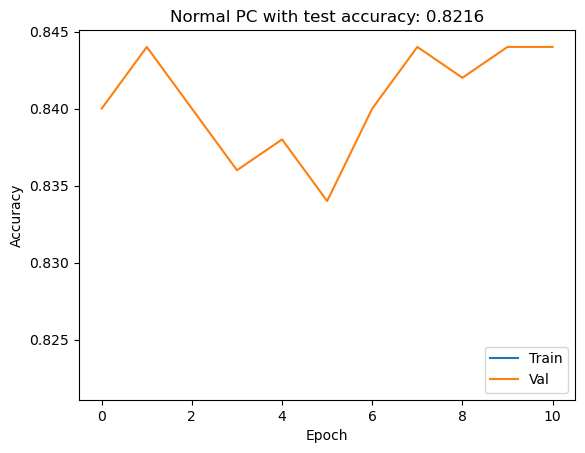

In [357]:
epochs = 10
batch_size = 500
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

best_val_acc = 0
best_model = copy.deepcopy(pc_normal.state_dict())

train_acc = [test_normal(pc_normal, test_dataset)]
val_acc = [test_normal(pc_normal, val_dataset)]
for epoch in range(epochs):
    for data, label in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
        data, label = data.to(device), label.to(device)
        # labels to one-hot
        labels_one_hot = F.one_hot(label).float()
        trainer_normal.train_on_batch(inputs=labels_one_hot, loss_fn=loss_fn_normal, loss_fn_kwargs={'_target':data}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
    # train_acc.append(test_normal(pc_normal, train_dataset))
    val_acc.append(test_normal(pc_normal, val_dataset))
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        best_model = copy.deepcopy(pc_normal.state_dict())
    print(f'Epoch {epoch+1} -  Val acc: {val_acc[-1]}')

    
test_model = get_model(input_size, hidden_size, hidden2_size, output_size, activation_fn, is_bias=False)
test_model.train()
test_model.load_state_dict(best_model, strict=False)
test_model.to(device)
acc_test = test_normal(test_model, test_dataset)
print(f'Test accuracy: {acc_test}')


plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Normal PC with test accuracy: {acc_test}')

100%|██████████| 10/10 [00:00<00:00, 971.62it/s]


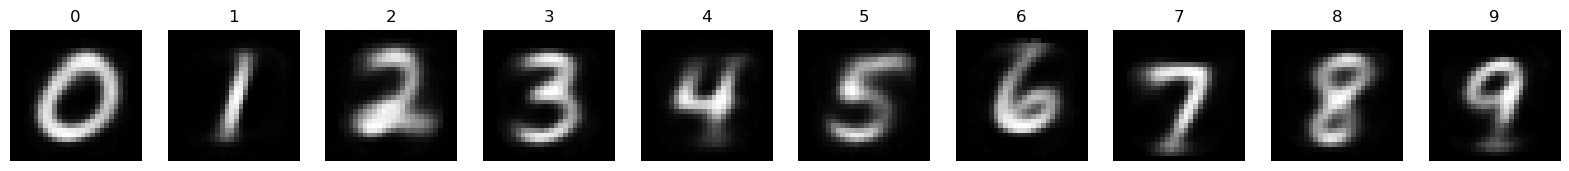

In [358]:
# conditional generation

# make pc_trainer for generation  
trainer_normal_generation = pc.PCTrainer(test_model, 
    T = 100, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = "never",   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

test_model.eval()

imgs = []
for i in tqdm(range(10)):
    input = torch.zeros(1, 10)
    input[0, i] = 1
    input = input.to(device)

    img = test_model(input)
    imgs.append(img.cpu().detach().numpy().reshape(28, 28))
    # results = trainer_normal_generation.train_on_batch(inputs=input, loss_fn=lambda x: torch.tensor(0), is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False, is_return_outputs=True)
    # imgs.append(results['outputs'][-1].cpu().detach().numpy().reshape(28, 28))

# show 10 images one for each digit
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].imshow(imgs[i], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'{i}')

In [289]:
def test_forward_pass(model, dataset):
    model.eval()
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=dataset.__len__(), shuffle=False)

    # 
    labels = torch.tensor([i for i in range(10)]).to(device)
    labels_one_hot = F.one_hot(labels, 10).float()
    map_ims = model(labels_one_hot)

    # for each data point finw which map ims is the closest
    data, label = next(iter(test_loader))
    data = data.to(device)
    energies = torch.zeros(data.shape[0], 10)
    for i in range(map_ims.shape[0]):
        dist = (data - map_ims[i]).pow(2).sum(-1)
        energies[:, i] = dist
    _, predicted = torch.min(energies, -1)
    print(predicted, label)
    accuracy =  (predicted == label).sum().item()/label.shape[0]
    model.train()
    errors = (predicted != label)
    return round(accuracy, 4), label, errors



def cov_energy_function(inputs):
    sharpness = 10
    reg = 1
    # precision = sharpness * torch.ones(1,inputs['x'].shape[-1],inputs['x'].shape[-1], device=inputs['x'].device)
    # energy = torch.matmul(inputs['x'] - inputs['mu'], precision) * (inputs['x'] - inputs['mu'])
    # add regularisation to prevent latent states to be biger that 1 or smaller than 1
    energy = reg*(inputs['x']<0).double()*(inputs['x'].abs()) + reg*(inputs['x']>1).double()*((inputs['x']-1).abs())
    return energy


def test_normal(model, dataset, batch_size=1000):
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # add bias layer for inferece
    test_model = nn.Sequential(
        BiasLayer(10, offset=0.1),
        pc.PCLayer(energy_fn= cov_energy_function),
        model
    )
    test_model.train()
    test_model.to(device)

    # make pc_trainer for test_model   
    trainer_normal_test = pc.PCTrainer(test_model, 
        T = 120, 
        update_x_at = update_x_at, 
        optimizer_x_fn = optimizer_x_fn,
        optimizer_x_kwargs = optimizer_x_kwargs,
        update_p_at = "never",   
        optimizer_p_fn = optimizer_p_fn,
        optimizer_p_kwargs = optimizer_p_kwargs,
        plot_progress_at= plot_progress_at
    )

    correct_count, all_count = 0., 0.
    for data, labels in (test_loader):
        pseudo_input = torch.zeros(data.shape[0], 10)
        data, labels, pseudo_input = data.to(device), labels.to(device), pseudo_input.to(device)
        
        # MAP inference
        trainer_normal_test.train_on_batch(inputs=pseudo_input, loss_fn=loss_fn_normal, loss_fn_kwargs={'_target':data} , callback_after_t=random_step, callback_after_t_kwargs={'_trainer':trainer_normal_test}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
        pred = torch.max(test_model[1].get_x(), dim=1)
        correct = (pred.indices == labels).long()
        correct_count += correct.sum()
        all_count += correct.size(0)
    return round((correct_count / all_count).item(), 4)


def test_multihead(test_model, dataset, batch_size=1000):
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    """
                    - This function is under development -
        This function finds the one-hot output with the lowest energy of each test data and compares it to the true label
        This should behave like a one-hot prior 
    """

    # make pc_trainer for test_model   
    pc_trainer = pc.PCTrainer(test_model, 
        T = 2000, 
        update_x_at = update_x_at, 
        optimizer_x_fn = optimizer_x_fn,
        optimizer_x_kwargs = optimizer_x_kwargs,
        update_p_at = "never",   
        optimizer_p_fn = optimizer_p_fn,
        optimizer_p_kwargs = optimizer_p_kwargs,
        plot_progress_at= plot_progress_at
    )
    

    correct_count, all_count = 0., 0.
    # set model pc layer to keep track of element wise energy
    layers = pc_trainer.get_model_pc_layers()
    for l in layers:
        l.is_keep_energy_per_datapoint = True

    for data, labels in tqdm(test_loader):
        batch_size = data.shape[0]
        
        linspace = torch.linspace(0,9,10).reshape(1,-1)
    
        pseudo = linspace.repeat(batch_size,1).T.reshape(-1).to(torch.int64)
        pseudo = torch.nn.functional.one_hot(pseudo, 10).to(data.dtype)
        
        data = data.repeat(10,1)
        data, pseudo = data.to(device), pseudo.to(device)
        # MAP inference
        results = pc_trainer.train_on_batch(inputs=pseudo, loss_fn=loss_fn_normal,loss_fn_kwargs={'_target':data},is_log_progress=False,is_return_results_every_t=False,is_checking_after_callback_after_t=False, is_return_batchelement_loss=True)
        pred = results["overall_elementwise"].reshape(10,batch_size).min(0)
        correct = (pred.indices.cpu() == labels).long()
        correct_count += correct.sum()
        all_count += correct.size(0)

    # reset each layer to not take element wise energies
    for l in layers:
        l.is_keep_energy_per_datapoint = False
    return (correct_count / all_count).cpu().item()



# test model accuracy with forward pass
acc_test, labels, errors = test_forward_pass(test_model, test_dataset)
print(f'Test accuracy: {acc_test}')

acc_test = test_normal(test_model, val_dataset)
print(f'Test accuracy: {acc_test}')

# test model accuracy with multihead
acc_test = test_multihead(test_model, val_dataset)
print(f'Test accuracy: {acc_test}')

tensor([9, 1, 7,  ..., 1, 1, 9]) tensor([9, 5, 7,  ..., 1, 1, 9])
Test accuracy: 0.8222
Test accuracy: 0.872


100%|██████████| 1/1 [00:14<00:00, 14.56s/it]

Test accuracy: 0.8999999761581421


(array([0.06872852, 0.02520046, 0.13745704, 0.10996564, 0.09851088,
        0.1534937 , 0.05956472, 0.09851088, 0.15463918, 0.09392898]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5]),
 <BarContainer object of 10 artists>)

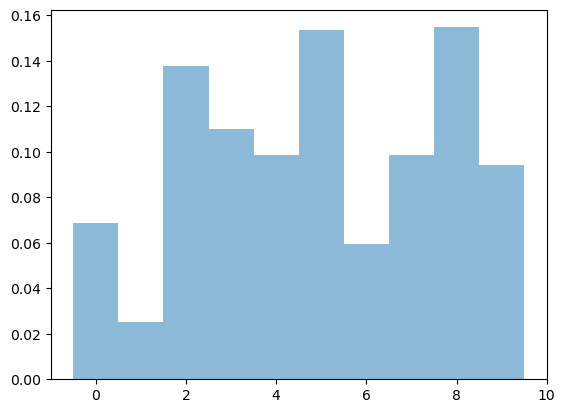

In [33]:
# define bins
bins = [i-0.5 for i in range(11)]
plt.hist(labels[errors].cpu().numpy(), density=True, bins=bins, alpha=0.5, label='Errors')

In [ ]:
# conditional generation

# make pc_trainer for generation  
trainer_normal_generation = pc.PCTrainer(test_model, 
    T = 100, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = "never",   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

test_model.train()

test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)
data, labels = next(iter(test_dataloader))
data, labels = data.to(device), labels.to(device)

def loss_fn_normal_masked(output, _target):
    return 0.5*(output[:,:28*28//2] - _target[:,:28*28//2]).pow(2).sum()

imgs = []
for i in tqdm(range(10)):
    # get one image from data with correct label
    idx = torch.where(labels == i)[0][0]
    img = data[idx].unsqueeze(0)
    label = torch.zeros(1, 10)
    label[0, i] = 1
    label = label.to(device)

    results = trainer_normal_generation.train_on_batch(inputs=label, loss_fn=loss_fn_normal_masked, loss_fn_kwargs={"_target": img}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False, is_return_outputs=True)
    
    output_img = results['outputs'][-1].cpu().detach().numpy().reshape(28, 28)
    output_img[:14, :] = img.cpu().detach().numpy().reshape(28, 28)[:14, :]
    imgs.append(output_img)

# show 10 images one for each digit
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].imshow(imgs[i], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'{i}')

In [29]:
# brute force tuning
x_optm = [optim.Adam, optim.SGD]
lr_x = [1e-3, 1e-2, 1e-1, 1]
p_optm = [optim.Adam, optim.SGD]
lr_p = [1e-3, 1e-2, 1e-1, 1]
weight_decay = [0, 1e-3, 1e-2, 1e-1]
activation_fns = [nn.ReLU, nn.Tanh]
best_val_acc_tuning = 0
best_params = None

for lr_x_ in tqdm(lr_x):
    for lr_p_ in lr_p:
        for weight_decay_ in weight_decay:
            for optimizer_x_fn in x_optm:
                for optimizer_p_fn in p_optm:
                    for activation_fn_ in activation_fns:
                        input_size = 10
                        hidden_size = 256
                        hidden2_size = 256
                        output_size = 28*28

                        pc_normal = get_model(input_size, hidden_size, hidden2_size, output_size, activation_fn_)
                        pc_normal.train()
                        pc_normal.to(device)

                        def loss_fn_normal(output, _target):
                            return 0.5*(output - _target).pow(2).sum()

                        T = 20                             # number of inference iterations
                        update_x_at = 'all'                 # update latent state x at every iteration
                        optimizer_x_fn = optimizer_x_fn         # optimizer for latent state x
                        optimizer_x_kwargs = {'lr': lr_x_}    # optimizer parameters for latent state x
                        update_p_at = 'last'                # update parameters p at the last iteration
                        optimizer_p_fn = optimizer_p_fn          # optimizer for parameters p
                        optimizer_p_kwargs = {"lr": lr_p_, "weight_decay": weight_decay_} # optimizer parameters for parameters p
                        plot_progress_at = []            # plot progress every inference iterations

                        trainer_normal = pc.PCTrainer(pc_normal, 
                            T = T, 
                            update_x_at = update_x_at, 
                            optimizer_x_fn = optimizer_x_fn,
                            optimizer_x_kwargs = optimizer_x_kwargs,
                            update_p_at = update_p_at,   
                            optimizer_p_fn = optimizer_p_fn,
                            optimizer_p_kwargs = optimizer_p_kwargs,
                            plot_progress_at= plot_progress_at
                        )

                        # This class contains the parameters of the prior mean \mu parameter (see figure)
                        class BiasLayer(nn.Module):
                            def __init__(self, out_features, offset=0.):
                                super(BiasLayer, self).__init__()
                                self.bias = nn.Parameter(offset*torch.ones(out_features) if offset is not None else 2*np.sqrt(out_features)*torch.rand(out_features)-np.sqrt(out_features), requires_grad=True)

                            def forward(self, x):
                                return torch.zeros_like(x) + self.bias  # return the prior mean \mu witht the same shape as the input x to make sure the batch size is the same


                        def test_normal(model, dataset, batch_size=1000):
                            test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

                            # add bias layer for inferece
                            test_model = nn.Sequential(
                                BiasLayer(10, offset=0.),
                                pc.PCLayer(),
                                model
                            )
                            test_model.train()
                            test_model.to(device)

                            # make pc_trainer for test_model   
                            trainer_normal_test = pc.PCTrainer(test_model, 
                                T = 100, 
                                update_x_at = update_x_at, 
                                optimizer_x_fn = optimizer_x_fn,
                                optimizer_x_kwargs = optimizer_x_kwargs,
                                update_p_at = "never",   
                                optimizer_p_fn = optimizer_p_fn,
                                optimizer_p_kwargs = optimizer_p_kwargs,
                                plot_progress_at= plot_progress_at
                            )

                            correct_count, all_count = 0., 0.
                            for data, labels in (test_loader):
                                pseudo_input = torch.zeros(data.shape[0], 10)
                                data, labels, pseudo_input = data.to(device), labels.to(device), pseudo_input.to(device)
                                
                                # MAP inference
                                trainer_normal_test.train_on_batch(inputs=pseudo_input, loss_fn=loss_fn_normal, loss_fn_kwargs={'_target':data}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
                                pred = torch.max(test_model[1].get_x(), dim=1)
                                correct = (pred.indices == labels).long()
                                correct_count += correct.sum()
                                all_count += correct.size(0)
                            return round((correct_count / all_count).item(), 4)
                        
                        epochs = 10
                        batch_size = 500
                        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

                        best_val_acc = 0
                        best_model = copy.deepcopy(pc_normal.state_dict())

                        train_acc = [test_normal(pc_normal, test_dataset)]
                        val_acc = [test_normal(pc_normal, val_dataset)]
                        for epoch in range(epochs):
                            for data, label in train_loader:
                                data, label = data.to(device), label.to(device)
                                # labels to one-hot
                                labels_one_hot = F.one_hot(label).float()
                                trainer_normal.train_on_batch(inputs=labels_one_hot, loss_fn=loss_fn_normal, loss_fn_kwargs={'_target':data}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
                            train_acc.append(test_normal(pc_normal, test_dataset))
                            val_acc.append(test_normal(pc_normal, val_dataset))
                            if val_acc[-1] > best_val_acc:
                                best_val_acc = val_acc[-1]
                       
                        if best_val_acc > best_val_acc_tuning:
                            best_val_acc_tuning = best_val_acc
                            best_params = (lr_x_, lr_p_, weight_decay_, optimizer_x_fn, optimizer_p_fn, activation_fn_)
                            print(f'Best val acc: {best_val_acc_tuning}, Best params - lr_x:{best_params[0]}, lr_p:{best_params[1]}, weight_decay:{best_params[2]}, optimizer_x_fn:{best_params[3]}, optimizer_p_fn:{best_params[4]}, activation_fn:{best_params[5]}')

print(f'Best val acc: {best_val_acc_tuning}, Best params - lr_x:{best_params[0]}, lr_p:{best_params[1]}, weight_decay:{best_params[2]}, optimizer_x_fn:{best_params[3]}, optimizer_p_fn:{best_params[4]}, activation_fn:{best_params[5]}')

  0%|          | 0/4 [00:00<?, ?it/s]

Best val acc: 0.802, Best params - lr_x:0.001, lr_p:0.001, weight_decay:0, optimizer_x_fn:<class 'torch.optim.adam.Adam'>, optimizer_p_fn:<class 'torch.optim.adam.Adam'>, activation_fn:<class 'torch.nn.modules.activation.ReLU'>
Best val acc: 0.814, Best params - lr_x:0.001, lr_p:0.001, weight_decay:0, optimizer_x_fn:<class 'torch.optim.adam.Adam'>, optimizer_p_fn:<class 'torch.optim.adam.Adam'>, activation_fn:<class 'torch.nn.modules.activation.Tanh'>
Best val acc: 0.818, Best params - lr_x:0.001, lr_p:0.001, weight_decay:0, optimizer_x_fn:<class 'torch.optim.adam.Adam'>, optimizer_p_fn:<class 'torch.optim.sgd.SGD'>, activation_fn:<class 'torch.nn.modules.activation.ReLU'>
Best val acc: 0.842, Best params - lr_x:0.001, lr_p:0.001, weight_decay:0, optimizer_x_fn:<class 'torch.optim.adam.Adam'>, optimizer_p_fn:<class 'torch.optim.sgd.SGD'>, activation_fn:<class 'torch.nn.modules.activation.Tanh'>
Best val acc: 0.856, Best params - lr_x:0.001, lr_p:0.001, weight_decay:0.001, optimizer_x_f

 25%|██▌       | 1/4 [2:00:13<6:00:39, 7213.28s/it]

Best val acc: 0.862, Best params - lr_x:0.01, lr_p:0.001, weight_decay:0, optimizer_x_fn:<class 'torch.optim.adam.Adam'>, optimizer_p_fn:<class 'torch.optim.adam.Adam'>, activation_fn:<class 'torch.nn.modules.activation.Tanh'>
Best val acc: 0.868, Best params - lr_x:0.01, lr_p:0.001, weight_decay:0, optimizer_x_fn:<class 'torch.optim.adam.Adam'>, optimizer_p_fn:<class 'torch.optim.sgd.SGD'>, activation_fn:<class 'torch.nn.modules.activation.Tanh'>
Best val acc: 0.87, Best params - lr_x:0.01, lr_p:0.001, weight_decay:0.001, optimizer_x_fn:<class 'torch.optim.adam.Adam'>, optimizer_p_fn:<class 'torch.optim.adam.Adam'>, activation_fn:<class 'torch.nn.modules.activation.ReLU'>
Best val acc: 0.876, Best params - lr_x:0.01, lr_p:0.001, weight_decay:0.001, optimizer_x_fn:<class 'torch.optim.adam.Adam'>, optimizer_p_fn:<class 'torch.optim.sgd.SGD'>, activation_fn:<class 'torch.nn.modules.activation.Tanh'>


 50%|█████     | 2/4 [4:00:04<4:00:00, 7200.23s/it]

Best val acc: 0.896, Best params - lr_x:0.1, lr_p:0.001, weight_decay:0.001, optimizer_x_fn:<class 'torch.optim.adam.Adam'>, optimizer_p_fn:<class 'torch.optim.adam.Adam'>, activation_fn:<class 'torch.nn.modules.activation.ReLU'>


100%|██████████| 4/4 [7:59:53<00:00, 7198.35s/it]  

Best val acc: 0.896, Best params - lr_x:0.1, lr_p:0.001, weight_decay:0.001, optimizer_x_fn:<class 'torch.optim.adam.Adam'>, optimizer_p_fn:<class 'torch.optim.adam.Adam'>, activation_fn:<class 'torch.nn.modules.activation.ReLU'>


V -model: dual model with a generative 'image' model and a label decoder.

100%|██████████| 20/20 [00:02<00:00,  9.72it/s]


Val accuracy: 0.096


100%|██████████| 20/20 [00:02<00:00,  9.68it/s]


Val accuracy: 0.102


100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


Val accuracy: 0.138


100%|██████████| 20/20 [00:02<00:00,  8.67it/s]


Val accuracy: 0.712


100%|██████████| 20/20 [00:02<00:00,  9.21it/s]


Val accuracy: 0.534


100%|██████████| 20/20 [00:02<00:00,  9.50it/s]


Val accuracy: 0.742


100%|██████████| 20/20 [00:02<00:00,  9.49it/s]


Val accuracy: 1.0


100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


Val accuracy: 1.0


100%|██████████| 20/20 [00:02<00:00,  9.61it/s]


Val accuracy: 1.0


100%|██████████| 20/20 [00:02<00:00,  9.33it/s]


Val accuracy: 1.0
Test accuracy: 1.0


Text(0.5, 1.0, 'PC-V model with test accuracy: 1.0')

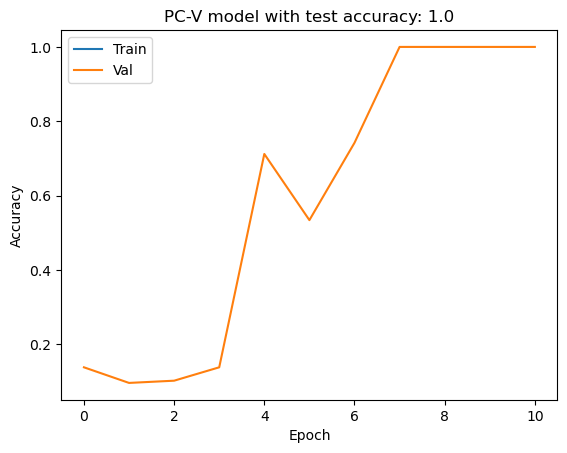

In [81]:
# set seed 
torch.manual_seed(0)

x_optm = optim.Adam
lr_x = 1
p_optm = optim.Adam
lr_p =  1e-2
weight_decay = 0.001
activation_fns = nn.ReLU

input_size = 10
latent_size = 10
hidden_size = 256
hidden2_size = 256
output_size = 28*28


class PC_V_model(nn.Module):
    def __init__(self, input_size, latent_size, output_size, hidden_size, hidden2_size, activation_fn):
        super(PC_V_model, self).__init__()
        self.head = nn.Sequential(
            BiasLayer(latent_size, offset=None),
            pc.PCLayer(),
        )
        self.encoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            pc.PCLayer(),
            activation_fn(),
            nn.Linear(hidden_size, hidden2_size),
            pc.PCLayer(),
            activation_fn(),
            nn.Linear(hidden2_size, output_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, input_size),
        )
        
    def forward(self, x):
        latent = self.head(x)
        return torch.cat((self.encoder(latent), self.decoder(latent)), dim=1)


pc_v_model = PC_V_model(input_size, latent_size, output_size, hidden_size, hidden2_size, activation_fn)
pc_v_model.train()
pc_v_model.to(device)

CE_loss = nn.CrossEntropyLoss()
def loss_fn_v_model(output, _image, _label):
    return 0.5*(output[:,:_image.shape[1]] - _image).pow(2).sum() + CE_loss(output[:,_image.shape[1]:], _label)

# CE_loss = nn.CrossEntropyLoss()
# img_loss = nn.BCEWithLogitsLoss(reduction="sum")
    
# def loss_fn_v_model(output, _image, _label):
#     return img_loss(output[:,:_image.shape[1]], _image)  + 0.1*CE_loss(output[:,_image.shape[1]:], _label)


T = 20                             # number of inference iterations
update_x_at = 'all'                 # update latent state x at every iteration
optimizer_x_fn = x_optm         # optimizer for latent state x
optimizer_x_kwargs = {'lr': lr_x}    # optimizer parameters for latent state x
update_p_at = 'last'                # update parameters p at the last iteration
optimizer_p_fn = p_optm         # optimizer for parameters p
optimizer_p_kwargs = {"lr": lr_p, "weight_decay":weight_decay} # optimizer parameters for parameters p
plot_progress_at = []            # plot progress every inference iterations

trainer_v_model = pc.PCTrainer(pc_v_model, 
    T = T, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = update_p_at,   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

# trainer_v_model.set_optimizer_p(optim.Adam(pc_v_model.decoder.parameters(), lr=0.0001, weight_decay=0.01, betas=(0.9,0.999)))

def test_v_model(model, dataset, batch_size=1000):
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # make pc_trainer for test_model   
    trainer_test = pc.PCTrainer(model, 
        T = 200, 
        update_x_at = update_x_at, 
        optimizer_x_fn = optimizer_x_fn,
        optimizer_x_kwargs = optimizer_x_kwargs,
        update_p_at = "never",   
        optimizer_p_fn = optimizer_p_fn,
        optimizer_p_kwargs = optimizer_p_kwargs,
        plot_progress_at= plot_progress_at
    )

    correct_count, all_count = 0., 0.
    for data, labels in (test_loader):
        pseudo_input = torch.zeros(data.shape[0], latent_size)
        data, labels, pseudo_input = data.to(device), labels.to(device), pseudo_input.to(device)
        labels_one_hot = F.one_hot(labels).float()
        # MAP inference
        results = trainer_test.train_on_batch(inputs=pseudo_input, loss_fn=loss_fn_v_model, loss_fn_kwargs={'_image':data, '_label':labels_one_hot}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False, is_return_outputs=True)
        output = results["outputs"][-1]
        pred = torch.max(output[:, data.shape[1]:], dim=1)
        correct = (pred.indices == labels).long()
        correct_count += correct.sum()
        all_count += correct.size(0)
    return round((correct_count / all_count).item(), 4)
epochs = 10
batch_size = 512
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

best_val_acc = 0
best_model = copy.deepcopy(pc_v_model.state_dict())

train_acc = [test_v_model(pc_v_model, test_dataset)]
val_acc = [test_v_model(pc_v_model, val_dataset)]
for epoch in range(epochs):
    for data, labels in tqdm(train_loader):
        pseudo_input = torch.zeros(data.shape[0], latent_size)
        data, labels, pseudo_input = data.to(device), labels.to(device), pseudo_input.to(device)
        labels_one_hot = F.one_hot(labels).float()
        trainer_v_model.train_on_batch(inputs=pseudo_input, loss_fn=loss_fn_v_model, loss_fn_kwargs={'_image':data, '_label':labels_one_hot}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
    # train_acc.append(test_v_model(pc_v_model, train_dataset))
    val_acc.append(test_v_model(pc_v_model, val_dataset))
    # print("Train accuracy:", train_acc[-1])
    print("Val accuracy:", val_acc[-1])
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        best_model = copy.deepcopy(pc_v_model.state_dict())


test_model =  PC_V_model(input_size, latent_size, output_size, hidden_size, hidden2_size, activation_fn)
test_model.train()
test_model.load_state_dict(best_model, strict=False)
test_model.to(device)
acc_test = test_v_model(test_model, test_dataset)
print(f'Test accuracy: {acc_test}')

plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'PC-V model with test accuracy: {acc_test}')


100%|██████████| 10/10 [00:26<00:00,  2.69s/it]


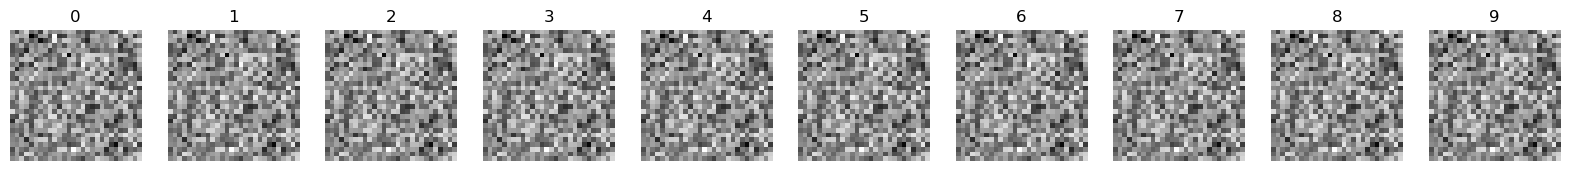

In [82]:
"""
    This likely doesn't work because the latent layer is too large so we are only really training the decoder
"""

# conditional generation
# make pc_trainer for generation  
trainer_v_model_generation = pc.PCTrainer(test_model, 
    T = 1000, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = "never",   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)

def loss_fn_v_model_generation(output, _label):
    return CE_loss(output[:,-_label.shape[1]:], _label)


imgs = []
for i in tqdm(range(10)):
    input = torch.zeros(1, 10)
    input[0, i] = 1
    input = input.to(device)
    pseudo_input = torch.zeros(1, latent_size).to(device)
    results = trainer_v_model_generation.train_on_batch(inputs=pseudo_input, loss_fn=loss_fn_v_model_generation, loss_fn_kwargs={'_label':input}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False, is_return_outputs=True)
    imgs.append((results['outputs'][-1][:,:28*28]).cpu().detach().numpy().reshape(28, 28))

# show 10 images one for each digit
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].imshow(imgs[i], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'{i}')

In [10]:

x_optm = [optim.Adam, optim.SGD]
lr_x = [1e-3, 1e-2, 1e-1, 1]
p_optm = [optim.Adam, optim.SGD]
lr_p = [1e-3, 1e-2, 1e-1, 1]
weight_decay = [0, 1e-3, 1e-2, 1e-1]
activation_fns = [nn.ReLU, nn.Tanh]
best_val_acc_tuning = 0
best_params = None

for lr_x_ in tqdm(lr_x):
    for lr_p_ in lr_p:
        for weight_decay_ in weight_decay:
            for optimizer_x_fn in x_optm:
                for optimizer_p_fn in p_optm:
                    for activation_fn_ in activation_fns:
                        input_size = 10
                        latent_size = 10
                        hidden_size = 256
                        hidden2_size = 256
                        output_size = 28*28

                        # activation_fn = nn.ReLU
                        # # activation_fn = nn.Tanh


                        class PC_V_model(nn.Module):
                            def __init__(self, input_size, latent_size, output_size, hidden_size, hidden2_size, activation_fn):
                                super(PC_V_model, self).__init__()
                                self.head = nn.Sequential(
                                    BiasLayer(latent_size, offset=None),
                                    pc.PCLayer(),
                                )
                                self.encoder = nn.Sequential(
                                    nn.Linear(latent_size, hidden_size),
                                    pc.PCLayer(),
                                    activation_fn(),
                                    nn.Linear(hidden_size, hidden2_size),
                                    pc.PCLayer(),
                                    activation_fn(),
                                    nn.Linear(hidden2_size, output_size)
                                )
                                self.decoder = nn.Sequential(
                                    nn.Linear(latent_size, input_size),
                                )
                                
                            def forward(self, x):
                                latent = self.head(x)
                                return torch.cat((self.encoder(latent), self.decoder(latent)), dim=1)


                        pc_v_model = PC_V_model(input_size, latent_size, output_size, hidden_size, hidden2_size, activation_fn)
                        pc_v_model.train()
                        pc_v_model.to(device)

                        CE_loss = nn.CrossEntropyLoss()
                        img_loss = nn.BCEWithLogitsLoss(reduction="sum")
                        
                        def loss_fn_v_model(output, _image, _label):
                            return img_loss(output[:,:_image.shape[1]], _image)  + CE_loss(output[:,_image.shape[1]:], _label)

                        # def loss_fn_v_model(output, _image, _label):
                        #     return 0.5*(output[:,:_image.shape[1]] - _image).pow(2).sum() + 0.1*CE_loss(output[:,_image.shape[1]:], _label)

                        T = 20                             # number of inference iterations
                        update_x_at = 'all'                 # update latent state x at every iteration
                        optimizer_x_fn = optimizer_x_fn         # optimizer for latent state x
                        optimizer_x_kwargs = {'lr': lr_x_}    # optimizer parameters for latent state x
                        update_p_at = 'last'                # update parameters p at the last iteration
                        optimizer_p_fn = optimizer_p_fn         # optimizer for parameters p
                        optimizer_p_kwargs = {"lr": lr_p_, "weight_decay":weight_decay_} # optimizer parameters for parameters p
                        plot_progress_at = []            # plot progress every inference iterations

                        trainer_v_model = pc.PCTrainer(pc_v_model, 
                            T = T, 
                            update_x_at = update_x_at, 
                            optimizer_x_fn = optimizer_x_fn,
                            optimizer_x_kwargs = optimizer_x_kwargs,
                            update_p_at = update_p_at,   
                            optimizer_p_fn = optimizer_p_fn,
                            optimizer_p_kwargs = optimizer_p_kwargs,
                            plot_progress_at= plot_progress_at
                        )

                        # trainer_v_model.set_optimizer_p(optim.Adam(pc_v_model.decoder.parameters(), lr=0.0001, weight_decay=0.01, betas=(0.9,0.999)))

                        def test_v_model(model, dataset, batch_size=1000):
                            test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

                            # make pc_trainer for test_model   
                            trainer_test = pc.PCTrainer(model, 
                                T = 200, 
                                update_x_at = update_x_at, 
                                optimizer_x_fn = optimizer_x_fn,
                                optimizer_x_kwargs = optimizer_x_kwargs,
                                update_p_at = "never",   
                                optimizer_p_fn = optimizer_p_fn,
                                optimizer_p_kwargs = optimizer_p_kwargs,
                                plot_progress_at= plot_progress_at
                            )

                            correct_count, all_count = 0., 0.
                            for data, labels in (test_loader):
                                pseudo_input = torch.zeros(data.shape[0], latent_size)
                                data, labels, pseudo_input = data.to(device), labels.to(device), pseudo_input.to(device)
                                labels_one_hot = F.one_hot(labels).float()
                                # MAP inference
                                results = trainer_test.train_on_batch(inputs=pseudo_input, loss_fn=loss_fn_v_model, loss_fn_kwargs={'_image':data, '_label':labels_one_hot}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False, is_return_outputs=True)
                                output = results["outputs"][-1]
                                pred = torch.max(output[:, data.shape[1]:], dim=1)
                                correct = (pred.indices == labels).long()
                                correct_count += correct.sum()
                                all_count += correct.size(0)
                            return round((correct_count / all_count).item(), 4)
                        epochs = 10
                        batch_size = 512
                        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

                        best_val_acc = 0
                        best_model = copy.deepcopy(pc_v_model.state_dict())

                        train_acc = [test_v_model(pc_v_model, test_dataset)]
                        val_acc = [test_v_model(pc_v_model, val_dataset)]
                        for epoch in range(epochs):
                            for data, labels in train_loader:
                                pseudo_input = torch.zeros(data.shape[0], latent_size)
                                data, labels, pseudo_input = data.to(device), labels.to(device), pseudo_input.to(device)
                                labels_one_hot = F.one_hot(labels).float()
                                trainer_v_model.train_on_batch(inputs=pseudo_input, loss_fn=loss_fn_v_model, loss_fn_kwargs={'_image':data, '_label':labels_one_hot}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
                            train_acc.append(test_v_model(pc_v_model, test_dataset))
                            val_acc.append(test_v_model(pc_v_model, val_dataset))
                            if val_acc[-1] > best_val_acc:
                                best_val_acc = val_acc[-1]
                                best_model = copy.deepcopy(pc_v_model.state_dict())
                            # print(f'Epoch {epoch+1} - Train acc: {train_acc[-1]}, Val acc: {val_acc[-1]}')

                        if best_val_acc > best_val_acc_tuning:
                            print(f'Best val acc: {best_val_acc}, Best params: "lr_x": {lr_x_}, "lr_p": {lr_p_}, "weight_decay": {weight_decay_}, "activation_fn": {activation_fn_}, "optimizer_x_fn": {optimizer_x_fn}, "optimizer_p_fn": {optimizer_p_fn}')
                            best_val_acc_tuning = best_val_acc
                            best_params = {"lr_x": lr_x_, "lr_p": lr_p_, "weight_decay": weight_decay_}

print(f'Best val acc: {best_val_acc_tuning}, Best params: {best_params}')

  0%|          | 0/4 [00:00<?, ?it/s]

Best val acc: 0.158, Best params: "lr_x": 0.001, "lr_p": 0.001, "weight_decay": 0, "activation_fn": <class 'torch.nn.modules.activation.ReLU'>, "optimizer_x_fn": <class 'torch.optim.adam.Adam'>, "optimizer_p_fn": <class 'torch.optim.adam.Adam'>
Best val acc: 0.17, Best params: "lr_x": 0.001, "lr_p": 0.001, "weight_decay": 0, "activation_fn": <class 'torch.nn.modules.activation.Tanh'>, "optimizer_x_fn": <class 'torch.optim.adam.Adam'>, "optimizer_p_fn": <class 'torch.optim.adam.Adam'>
Best val acc: 0.172, Best params: "lr_x": 0.001, "lr_p": 0.001, "weight_decay": 0.001, "activation_fn": <class 'torch.nn.modules.activation.ReLU'>, "optimizer_x_fn": <class 'torch.optim.adam.Adam'>, "optimizer_p_fn": <class 'torch.optim.adam.Adam'>
Best val acc: 0.268, Best params: "lr_x": 0.001, "lr_p": 0.1, "weight_decay": 0.001, "activation_fn": <class 'torch.nn.modules.activation.ReLU'>, "optimizer_x_fn": <class 'torch.optim.sgd.SGD'>, "optimizer_p_fn": <class 'torch.optim.adam.Adam'>


 25%|██▌       | 1/4 [2:14:29<6:43:29, 8069.68s/it]

Best val acc: 0.302, Best params: "lr_x": 0.01, "lr_p": 0.1, "weight_decay": 0, "activation_fn": <class 'torch.nn.modules.activation.Tanh'>, "optimizer_x_fn": <class 'torch.optim.sgd.SGD'>, "optimizer_p_fn": <class 'torch.optim.adam.Adam'>


 50%|█████     | 2/4 [4:28:55<4:28:55, 8067.60s/it]

Best val acc: 0.344, Best params: "lr_x": 0.1, "lr_p": 0.001, "weight_decay": 0, "activation_fn": <class 'torch.nn.modules.activation.ReLU'>, "optimizer_x_fn": <class 'torch.optim.adam.Adam'>, "optimizer_p_fn": <class 'torch.optim.adam.Adam'>
Best val acc: 0.972, Best params: "lr_x": 0.1, "lr_p": 0.01, "weight_decay": 0, "activation_fn": <class 'torch.nn.modules.activation.ReLU'>, "optimizer_x_fn": <class 'torch.optim.adam.Adam'>, "optimizer_p_fn": <class 'torch.optim.adam.Adam'>


 75%|███████▌  | 3/4 [6:43:21<2:14:26, 8066.93s/it]

Best val acc: 1.0, Best params: "lr_x": 1, "lr_p": 0.01, "weight_decay": 0.001, "activation_fn": <class 'torch.nn.modules.activation.Tanh'>, "optimizer_x_fn": <class 'torch.optim.adam.Adam'>, "optimizer_p_fn": <class 'torch.optim.adam.Adam'>


100%|██████████| 4/4 [8:57:49<00:00, 8067.44s/it]  

Best val acc: 1.0, Best params: {'lr_x': 1, 'lr_p': 0.01, 'weight_decay': 0.001}


MCPC test

In [247]:
input_size = 10
hidden_size = 256
hidden2_size = 256
output_size = 28*28

activation_fn = nn.ReLU
# activation_fn = nn.Tanh

T = 50                             # number of inference iterations
update_x_at = 'all'                 # update latent state x at every iteration
optimizer_x_fn = optim.SGD         # optimizer for latent state x
optimizer_x_kwargs = {'lr': 0.1}    # optimizer parameters for latent state x
update_p_at = 'last'                # update parameters p at the last iteration
optimizer_p_fn = optim.Adam          # optimizer for parameters p
optimizer_p_kwargs = {"lr": 0.001, "weight_decay":0.001} # optimizer parameters for parameters p
plot_progress_at = []            # plot progress every inference iterations


def mcpc_energy_function(inputs, _lr, _var=2):
    return 0.5*(inputs['x'] - inputs['mu']).pow(2) + inputs['x']*torch.randn_like(inputs['x'])*np.sqrt(_var/_lr)


def get_model_mcpc(input_size, hidden_size, hidden2_size, output_size, activation_fn):
    return nn.Sequential(
        nn.Linear(input_size, hidden_size),
        pc.PCLayer(energy_fn=mcpc_energy_function, energy_fn_kwargs={'_lr': optimizer_x_kwargs['lr']}),
        activation_fn(),
        nn.Linear(hidden_size, hidden2_size),
        pc.PCLayer(energy_fn=mcpc_energy_function, energy_fn_kwargs={'_lr': optimizer_x_kwargs['lr']}),
        activation_fn(),
        nn.Linear(hidden2_size, output_size)
    )


pc_normal = get_model_mcpc(input_size, hidden_size, hidden2_size, output_size, activation_fn)
pc_normal.train()
pc_normal.to(device)

def loss_fn_normal(output, _target):
    return 0.5*(output - _target).pow(2).sum()

trainer_normal = pc.PCTrainer(pc_normal, 
    T = T, 
    update_x_at = update_x_at, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = update_p_at,   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at= plot_progress_at
)


def test_mcpc(model, dataset, batch_size=1000):
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # add bias layer for inferece
    test_model = nn.Sequential(
        BiasLayer(10, offset=0.1),
        pc.PCLayer(energy_fn= lambda inputs: torch.tensor(0)),
        model
    )
    test_model.train()
    test_model.to(device)

    # make pc_trainer for test_model   
    trainer_normal_test = pc.PCTrainer(test_model, 
        T = 200, 
        update_x_at = update_x_at, 
        optimizer_x_fn = optimizer_x_fn,
        optimizer_x_kwargs = optimizer_x_kwargs,
        update_p_at = "never",   
        optimizer_p_fn = optimizer_p_fn,
        optimizer_p_kwargs = optimizer_p_kwargs,
        plot_progress_at= plot_progress_at
    )

    correct_count, all_count = 0., 0.
    for data, labels in (test_loader):
        pseudo_input = torch.zeros(data.shape[0], 10)
        data, labels, pseudo_input = data.to(device), labels.to(device), pseudo_input.to(device)
        
        # MAP inference
        trainer_normal_test.train_on_batch(inputs=pseudo_input, loss_fn=loss_fn_normal, loss_fn_kwargs={'_target':data}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
        pred = torch.max(test_model[1].get_x(), dim=1)
        correct = (pred.indices == labels).long()
        correct_count += correct.sum()
        all_count += correct.size(0)
    return round((correct_count / all_count).item(), 4)

Epoch 1: 100%|██████████| 20/20 [00:03<00:00,  6.57it/s]


Epoch 1 -  Val acc: 0.104


Epoch 2: 100%|██████████| 20/20 [00:02<00:00,  6.70it/s]


Epoch 2 -  Val acc: 0.108


Epoch 3: 100%|██████████| 20/20 [00:03<00:00,  6.66it/s]


Epoch 3 -  Val acc: 0.114


Epoch 4: 100%|██████████| 20/20 [00:03<00:00,  6.66it/s]


Epoch 4 -  Val acc: 0.14


Epoch 5: 100%|██████████| 20/20 [00:03<00:00,  6.60it/s]


Epoch 5 -  Val acc: 0.128


Epoch 6: 100%|██████████| 20/20 [00:02<00:00,  6.69it/s]


Epoch 6 -  Val acc: 0.168


Epoch 7: 100%|██████████| 20/20 [00:03<00:00,  6.52it/s]


Epoch 7 -  Val acc: 0.188


Epoch 8: 100%|██████████| 20/20 [00:03<00:00,  6.63it/s]


Epoch 8 -  Val acc: 0.188


Epoch 9: 100%|██████████| 20/20 [00:02<00:00,  6.70it/s]


Epoch 9 -  Val acc: 0.258


Epoch 10: 100%|██████████| 20/20 [00:03<00:00,  6.56it/s]


Epoch 10 -  Val acc: 0.196
Test accuracy: 0.2428


Text(0.5, 1.0, 'Normal PC with test accuracy: 0.2428')

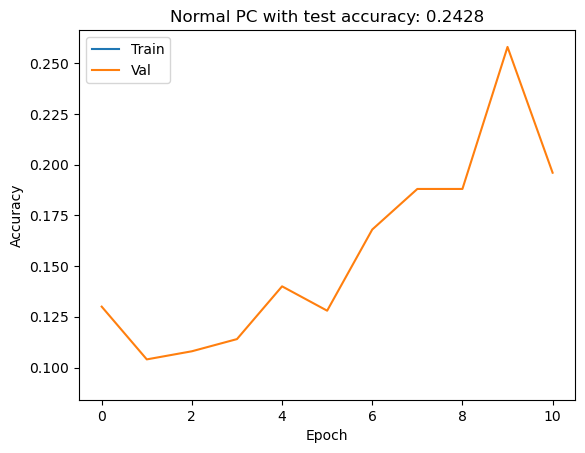

In [248]:
epochs = 10
batch_size = 500
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

best_val_acc = 0
best_model = copy.deepcopy(pc_normal.state_dict())

train_acc = [test_normal(pc_normal, test_dataset)]
val_acc = [test_normal(pc_normal, val_dataset)]
for epoch in range(epochs):
    for data, label in tqdm(train_loader, desc=f'Epoch {epoch+1}'):
        data, label = data.to(device), label.to(device)
        # labels to one-hot
        labels_one_hot = F.one_hot(label).float()
        trainer_normal.train_on_batch(inputs=labels_one_hot, loss_fn=loss_fn_normal, loss_fn_kwargs={'_target':data}, is_log_progress=False, is_return_results_every_t=False, is_checking_after_callback_after_t=False)
    # train_acc.append(test_normal(pc_normal, train_dataset))
    val_acc.append(test_normal(pc_normal, val_dataset))
    if val_acc[-1] > best_val_acc:
        best_val_acc = val_acc[-1]
        best_model = copy.deepcopy(pc_normal.state_dict())
    print(f'Epoch {epoch+1} -  Val acc: {val_acc[-1]}')

    
test_model = get_model_mcpc(input_size, hidden_size, hidden2_size, output_size, activation_fn)
test_model.train()
test_model.load_state_dict(best_model, strict=False)
test_model.to(device)
acc_test = test_normal(test_model, test_dataset)
print(f'Test accuracy: {acc_test}')


plt.plot(train_acc, label='Train')
plt.plot(val_acc, label='Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Normal PC with test accuracy: {acc_test}')

100%|██████████| 10/10 [00:00<00:00, 1670.90it/s]


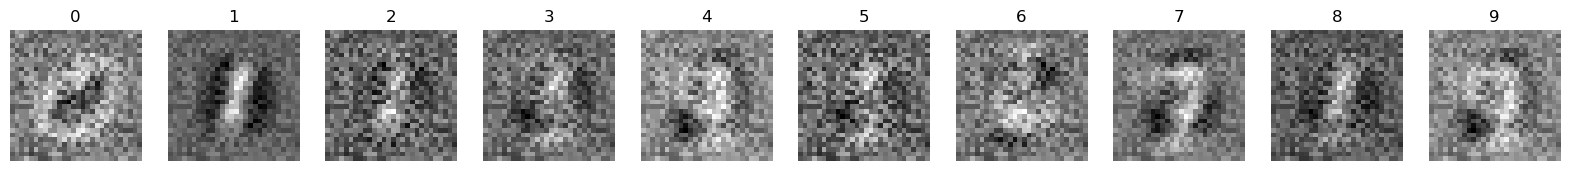

In [249]:
# conditional generation
test_model.eval()

imgs = []
for i in tqdm(range(10)):
    input = torch.zeros(1, 10)
    input[0, i] = 1
    input = input.to(device)

    img = test_model(input)
    imgs.append(img.cpu().detach().numpy().reshape(28, 28))

# show 10 images one for each digit
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    ax[i].imshow(imgs[i], cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'{i}')